In [39]:
# https://github.com/jim-schwoebel/voice_datasets
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import librosa
import math

In [40]:
import pandas as pd
metadata = pd.read_csv('./voices_dataset/speakers_all_original.csv')
metadata.head(10)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,patientId,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN
5,43.0,41.0,"port-au-prince, haiti",haitian,haitian,male,1167,haiti,True,NaN,NaN,NaN
6,21.0,21.0,"port-au-prince, haiti",haitian,haitian,male,1168,haiti,True,NaN,NaN,NaN
7,54.0,51.0,"port-au-prince, haiti",haitian,haitian,female,1169,haiti,True,NaN,NaN,NaN
8,18.0,16.0,"ouanaminthe, haiti",haitian,haitian,female,1866,haiti,True,NaN,NaN,NaN
9,73.0,5.0,"pepeekeo, hawai'i, usa",hawai'i,hawai'i,male,1675,usa,True,NaN,NaN,NaN


In [41]:
metadata = metadata[metadata['file_missing?'] == False]

In [290]:
metadata = metadata[metadata['native_language'] == 'english']
metadata['patientId'].value_counts()

usa                     373
uk                       65
canada                   44
australia                32
ireland                  11
new zealand               8
jamaica                   5
singapore                 4
south africa              4
panama                    3
india                     3
philippines               2
malaysia                  2
guyana                    2
virginia                  1
pakistan                  1
ghana                     1
lebanon                   1
nigeria                   1
papua new guinea          1
spain                     1
italy                     1
the bahamas               1
germany                   1
trinidad                  1
switzerland               1
liberia                   1
bolivia                   1
belize                    1
isle of man               1
us virgin islands         1
barbados                  1
antigua and barbuda       1
fiji                      1
united arab emirates      1
Name: country, dtype

In [228]:
metadata.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,patientId,Unnamed: 10,Unnamed: 11
363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,123.0,NaN,NaN
364,35.0,0.0,"davenport, iowa, usa",english10,english,female,62,usa,False,123.0,NaN,NaN
365,23.0,0.0,"miami, florida, usa",english100,english,female,63,usa,False,123.0,NaN,NaN
366,18.0,0.0,"toronto, ontario, canada",english101,english,female,64,canada,False,123.0,NaN,NaN
367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False,123.0,NaN,NaN


In [371]:
category_to_watch = 'patientId'

In [372]:
## Extracting MFCC'S for every audio file
audio_dataset_path = './voices_dataset/recordings_wav/'
num_mfcc = 13
n_fft = 2048
hop_length = 512
num_segments = 5
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

In [373]:


def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    # calculate start and finish sample for current segment
    start = samples_per_segment * 0
    finish = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(
      audio[start:finish],
      sample_rate,
      n_mfcc=num_mfcc,
      n_fft=n_fft,
      hop_length=hop_length
    )
    mfcc = mfcc.T
    
    return mfcc

In [374]:
import numpy as np
import os
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["filename"]) + str('-gain.wav'))
    final_class_labels=row[category_to_watch]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

0it [00:00, ?it/s]<ipython-input-373-74b9f73b7e3b>:8: FutureWarning: Pass y=[ 0.00318735  0.00493062  0.0052038  ...  0.01297772 -0.01695506
 -0.05303697], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
1it [00:00,  3.69it/s]<ipython-input-373-74b9f73b7e3b>:8: FutureWarning: Pass y=[-0.00628242 -0.00989114 -0.00848595 ... -0.03626343 -0.04790292
 -0.05358177], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
2it [00:00,  3.72it/s]<ipython-input-373-74b9f73b7e3b>:8: FutureWarning: Pass y=[-0.00013969 -0.00025813 -0.00021859 ... -0.00020406 -0.00021297
 -0.00022372], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
3it [00:00,  3.99it/s]<ipython-input-373-74b9f73b7e3b>:8: FutureWarning: Pass y=[ 5.9630484e-06  2.2935932e-07 -5

In [375]:
### converting extracted_features to pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features, columns=[
  'feature',
  category_to_watch
])

In [376]:
## Split the dataset into independent and dependent dataset
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df[category_to_watch].tolist())

In [377]:
X.shape

(579, 259, 13)

In [378]:
### Label encoding
y = np.array(pd.get_dummies(y))

In [379]:
y.shape

(579, 12)

In [380]:
### Train Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3)

In [381]:
# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [382]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn import metrics

In [383]:
## number of patietsId
num_labels = y.shape[1]
num_labels

12

In [384]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# build network topology
model = Sequential()

# 1st conv layer
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(tf.keras.layers.BatchNormalization())

# 2nd conv layer
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(tf.keras.layers.BatchNormalization())

# 3rd conv layer
model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model.add(tf.keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))

# output layer
model.add(tf.keras.layers.Dense(num_labels, activation='softmax'))

In [385]:
# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(
  X_train, 
  y_train, 
  validation_data=(X_validation, y_validation), 
  batch_size=32, 
  epochs=100
)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 257, 11, 32)       320       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 129, 6, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 129, 6, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 127, 4, 32)        9248      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 64, 2, 32)        0         
 g2D)                                                            
                                                      

In [387]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

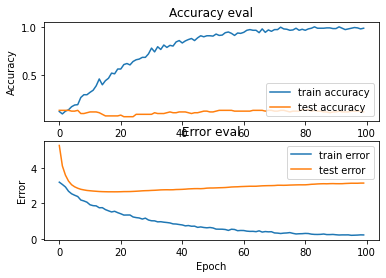

In [388]:
plot_history(history)

In [389]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

6/6 - 0s - loss: 3.0763 - accuracy: 0.1494 - 108ms/epoch - 18ms/step

Test accuracy: 0.14942528307437897


In [390]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))
    return predicted_index

In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[30]
y_to_predict = y_test[30]

In [482]:
# predict sample
predicted_classes = predict(model, X_to_predict, y_to_predict)
predicted_classes

Target: [0 0 0 0 1 0 0 0 0 0 0 0], Predicted label: [2]


array([2])

In [483]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(metadata[category_to_watch]))

prediction_class = labelencoder.inverse_transform(predicted_classes)
prediction_class


array([2345.])

# Test

In [514]:
test_filename = './voices_dataset/recordings_wav/english3-gain.wav'

audio, sample_rate = librosa.load(test_filename, res_type='kaiser_fast')
# calculate start and finish sample for current segment
start = samples_per_segment * 0
finish = start + samples_per_segment

# extract mfcc
mfcc = librosa.feature.mfcc(
  audio[start:finish],
  sample_rate,
  n_mfcc=num_mfcc,
  n_fft=n_fft,
  hop_length=hop_length
)
mfcc = mfcc.T

X_to_test = mfcc[..., np.newaxis]


predicted_classes = predict(model, X_to_test, y_to_predict)

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(metadata['patientId']))

prediction_class = labelencoder.inverse_transform(predicted_classes)
prediction_class

Target: [0 0 0 0 1 0 0 0 0 0 0 0], Predicted label: [0]


<ipython-input-514-a0f5e84fc533>:9: FutureWarning: Pass y=[-0.00143568 -0.00267515 -0.00134221 ...  0.02545444  0.02560174
  0.02690461], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(


array([123.])